In [53]:
import os  # Importar el módulo para operaciones del sistema
import numpy as np  # Importar NumPy para operaciones matemáticas y arreglos
import pandas as pd  # Importar Pandas para manipulación de datos
from shutil import copyfile  # Importar función para copiar archivos
import matplotlib.pyplot as plt  # Importar Matplotlib para graficar

from keras import backend as K  # Importar backend de Keras
from keras import layers as L  # Importar capas de Keras
from keras.models import Model, load_model  # Importar modelo y función para cargar modelos
from keras.regularizers import l2  # Importar regularizador L2
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping  # Importar callbacks para el entrenamiento

from tensorflow.keras.preprocessing import image  # Importar funciones de preprocesamiento de imágenes de Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Importar generador de datos de imágenes


In [54]:
# Crear un directorio para almacenar las imágenes
os.mkdir('./images/')
alpha = 'a'  # Inicializar la letra para los directorios
for i in range(0, 26):  # Crear directorios para cada letra de la A a la Z
    os.mkdir('./images/' + alpha)
    alpha = chr(ord(alpha) + 1)  # Pasar a la siguiente letra

rootdir = 'Braille_Dataset/'  # Directorio raíz del conjunto de datos
for file in os.listdir(rootdir):  # Recorrer los archivos en el directorio
    letter = file[0]  # Obtener la letra del archivo
    copyfile(rootdir + file, './images/' + letter + '/' + file)  # Copiar el archivo a su respectivo directorio


In [55]:
# Inicializar el generador de datos de imágenes con aumentos
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

# Crear un generador para el conjunto de entrenamiento
train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28, 28),
                                              subset='training')

# Crear un generador para el conjunto de validación
val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28, 28),
                                            subset='validation')

Found 832 images belonging to 26 classes.
Found 208 images belonging to 26 classes.


In [101]:
K.clear_session()  # Limpiar la sesión de Keras para evitar problemas de memoria

# Configurar los callbacks para el entrenamiento
model_ckpt = ModelCheckpoint('BrailleNet.keras', save_best_only=True)  # Guardar el mejor modelo
reduce_lr = ReduceLROnPlateau(patience=8, verbose=0)  # Reducir la tasa de aprendizaje si no hay mejora
early_stop = EarlyStopping(patience=15, verbose=1)  # Detener el entrenamiento si no hay mejora

# Definir la arquitectura del modelo
entry = L.Input(shape=(28, 28, 3))  # Entrada del modelo
x = L.SeparableConv2D(64, (3, 3), activation='relu')(entry)  # Primera capa convolucional separable
x = L.MaxPooling2D((2, 2))(x)  # Capa de max pooling
x = L.SeparableConv2D(128, (3, 3), activation='relu')(x)  # Segunda capa convolucional separable
x = L.MaxPooling2D((2, 2))(x)  # Capa de max pooling
x = L.SeparableConv2D(256, (2, 2), activation='relu')(x)  # Tercera capa convolucional separable
x = L.GlobalMaxPooling2D()(x)  # Capa de max pooling global
x = L.Dense(256)(x)  # Capa densa
x = L.LeakyReLU()(x)  # Activación LeakyReLU
x = L.Dense(64, kernel_regularizer=l2(2e-4))(x)  # Capa densa con regularización L2
x = L.LeakyReLU()(x)  # Activación LeakyReLU
x = L.Dense(26, activation='softmax')(x)  # Capa de salida con activación softmax

# Crear el modelo
model = Model(entry, x)
# Compilar el modelo con función de pérdida y optimizador
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=1000000,  # Número de épocas
    callbacks=[model_ckpt, reduce_lr, early_stop],  # Callbacks
    verbose=1  # Mostrar información del entrenamiento
)

Epoch 1/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.0367 - loss: 3.3252 - val_accuracy: 0.0385 - val_loss: 3.2730 - learning_rate: 0.0010
Epoch 2/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0404 - loss: 3.2683 - val_accuracy: 0.0673 - val_loss: 3.2421 - learning_rate: 0.0010
Epoch 3/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0609 - loss: 3.2246 - val_accuracy: 0.0721 - val_loss: 3.1001 - learning_rate: 0.0010
Epoch 4/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1114 - loss: 3.0502 - val_accuracy: 0.2260 - val_loss: 2.7741 - learning_rate: 0.0010
Epoch 5/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1972 - loss: 2.7556 - val_accuracy: 0.2308 - val_loss: 2.6577 - learning_rate: 0.0010
Epoch 6/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2986 - loss: 2.4545 - val_accuracy: 0.3798 - val_loss: 2.2207 - learning_rate: 0.0010
Epoch 7/1000000
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accura

In [95]:
model.summary()  # Resumen de la arquitectura del modelo

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 26, 26, 64)     │           283 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 11, 11, 128)    │         8,896 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 4, 4, 256)      │        33,536 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 379,937 (1.45 MB)

 Trainable params: 126,645 (494.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 253,292 (989.43 KB)

In [96]:
# Cargar el mejor modelo guardado
model = load_model('BrailleNet.keras')
acc = model.evaluate(val_generator)[1]  # Evaluar el modelo en el conjunto de validación
print('Precisión del modelo: {}'.format(round(acc, 4)))  # Mostrar la precisión del modelo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8939 - loss: 0.3987
Precisión del modelo: 0.9183


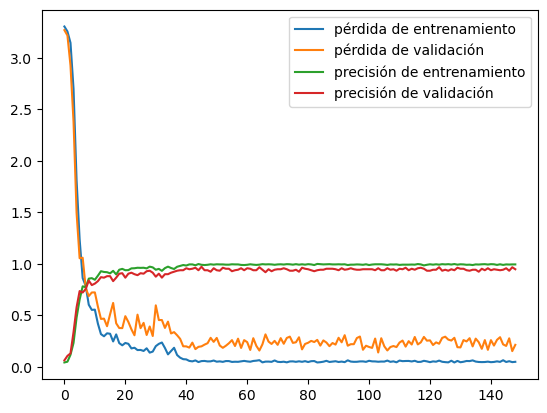

In [97]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='pérdida de validación')
plt.legend()
#plt.show()
plt.savefig('LossVal_loss')  # Guardar la gráfica de pérdida

# Graficar la precisión durante el entrenamiento
plt.plot(history.history['accuracy'], label='precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='precisión de validación')
plt.legend()
#plt.show()
plt.savefig('AccVal_acc')  # Guardar la gráfica de precisión

In [98]:
# Realizar predicciones en el conjunto de validación
pred = model.predict(val_generator)
pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[4.62196247e-20, 1.69411509e-29, 1.53247890e-15, ...,
        1.41542271e-08, 9.97891843e-01, 7.84144686e-06],
       [7.46667311e-12, 9.99999523e-01, 8.18804780e-16, ...,
        1.35254960e-20, 9.71917404e-23, 1.55092183e-16],
       [5.31516212e-21, 5.70672169e-17, 2.62778377e-15, ...,
        5.85383996e-14, 1.10042458e-06, 7.85180475e-07],
       ...,
       [3.75532766e-27, 8.45880771e-16, 1.13154358e-20, ...,
        1.19198208e-23, 3.81793918e-15, 3.44618317e-22],
       [1.83133981e-37, 2.08919930e-29, 3.76590180e-22, ...,
        4.77742166e-17, 2.64340040e-17, 1.27458481e-23],
       [4.11732097e-19, 3.45995940e-18, 9.98219720e-20, ...,
        1.28868296e-17, 4.88702238e-01, 1.94059267e-05]], dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
predicción =  [6]


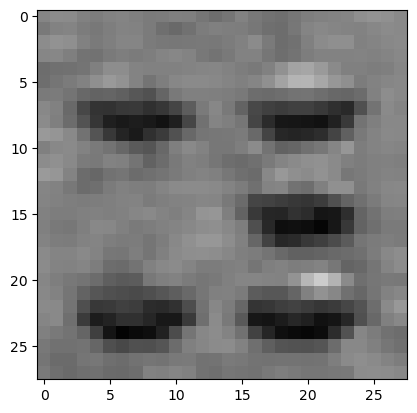

In [104]:
# Cargar y mostrar una imagen
from PIL import Image
import numpy as np

# Cargar la imagen
imagen = Image.open('prueba.jpg')

# Convertir la imagen a escala de grises
imagen_gris = imagen.convert('L')

# Convertir la imagen a un array numpy
imagen_array = np.array(imagen_gris)

# Normalizar la imagen a valores entre 0 y 1
imagen_normalizada = imagen_array / 255.0

# Opcional: Convertir de nuevo a la imagen de Pillow (si necesitas guardar o mostrar)
imagen_normalizada_pil = Image.fromarray((imagen_normalizada * 255).astype(np.uint8))

# Guardar la imagen normalizada en blanco y negro
imagen_normalizada_pil.save('imagen_normalizada_bn.jpg')

# Mostrar la imagen normalizada en blanco y negro (opcional)
imagen_normalizada_pil.show()


img = image.load_img('imagen_normalizada_bn.jpg')  # Cargar la imagen
plt.imshow(img)  # Mostrar la imagen

x = image.img_to_array(img)  # Convertir la imagen a un array
# print(x)  # Mostrar el array (comentar si no se necesita)

# print(x.shape)  # Mostrar la forma del array (comentar si no se necesita)

x = np.expand_dims(x, axis=0)  # Expandir dimensiones para la predicción
model.predict(x)  # Realizar la predicción

a = np.argmax(model.predict(x), axis=1)  # Obtener la clase predicha
print('predicción = ', a)  # Mostrar la clase predicha